In [220]:
import numpy as np
import scipy as sc
import cupy as cp
import matplotlib.pyplot as plt
import quantecon as qe
from scipy.optimize import minimize_scalar

In [221]:
print(cp.cuda.runtime.getDeviceCount())

1


In [222]:
print(cp.cuda.Device(0))

<CUDA Device 0>


Parameters

In [223]:
# P = [n_a, beta, theta, n_z, rho, sigma, mu, delta, gamma]
P = [101, 0.96, 2, 19, 0.95, 0.2, 0.1, 0.08, 1]

Expanding grid

In [224]:
def expanding_grid(params):

    zero_grid = np.linspace(0,1,params[0]).reshape(-1,1)

    asset_grid = np.zeros(shape=(params[0],1))

    a_low = 0

    a_high = 100

    for i in range(P[0]):
        asset_grid[i] = (a_low) + (a_high - a_low) * (zero_grid[i] ** P[2])

    return asset_grid

Utility

In [225]:
def u(c, params):
    if params[-1] == 1:
        return np.log(c)
    else:
        return ((c**(1-params[-1]))/(1-params[-1]))

Markov chain

In [226]:
def Markov_chain(params):

    n_z, rho, sigma, mu =  params[3], params[4], params[5], params[6]
    
  # mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    
    z_grid, T = mc.state_values, mc.P

    return z_grid, T

We now need the Bellman equation.

In [227]:
def B(V, G, params, r, w, T, A, Z, phi):

  # z_grid, T = Markov_chain(P)

  # asset_grid = expanding_grid(P)

  # V_init = cp.zeros(shape=(n_a, n_z))
  # V = cp.zeros(P[0], P[3])
  # G = cp.zeros(P[0], P[3])
                      
  #  if b>0:

  #      phi = cp.min([b, (w * cp.min(z_grid))/r])

  #  else:

  #      phi = b

    for j in range(params[3]):

        Expected_value = V * T[j,:]

        Interp_Ev = sc.interpolate.interp1d(np.squeeze(A), np.squeeze(Expected_value[:,j]), kind='cubic', fill_value='extrapolate')

        for i in range(params[0]):

                # Here, I have two methods for calculating the value and policy functions.
                # One method, "objective", uses a lambda function
                # The other uses "optimiser" (defined below)

                # objective = lambda a: - (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                def optimiser(a, params, A, Z, phi, w, Interp_Ev):
                  return - (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                lb = 0

                ub = (w * np.exp(Z[j])) + ((1+r) * A[i])

               # For "objective", we don't need to pass any args into the minimisation since it is taking in the lambda function             
               # result = minimize_scalar(objective, bounds = (lb, ub), method = 'bounded')
            
               # On the other hand, when using "optimiser", we do need to pass args into the mimimisation. 
                result = minimize_scalar(optimiser, bounds = (lb, ub), args = (params, A, Z, phi, w, Interp_Ev), method = 'bounded')
            
                argmax = result.x

                value = -result.fun

                # The final thing we need to do is set the min based on whether we are using "obj" or "opt"

                # min = np.float64(objective(0))

                min = optimiser(lb, params, A, Z, phi, w, Interp_Ev)

                if value < min:

                    G[i,j] = lb

                    V[i,j] = min
            
                else:

                    G[i,j] = argmax

                    V[i,j] = value                    

    return V, G    

Iterate on the Bellman equation

In [232]:
def iterate(params, r, w, b, toler, max_iter):

    iter = 0
    
    iter_error = toler + 1
    
    # z_grid, T = Markov_chain(params)
    
    # asset_grid = expanding_grid(params)

    V = np.zeros(shape=(params[0], params[3]))
    G = np.zeros(shape=(params[0], params[3]))
                      
    if b > 0 :

         phi = np.min([b, (w * np.min(z_grid))/r])

    else:

         phi = b

    while iter <= max_iter:

         V1, G1 = B(V, G, params, r, w, T, asset_grid, z_grid, phi)
        
         iter_error = np.max(np.abs(V1-V))

         iter +=1

         V = np.copy(V1)

         G = np.copy(G1)

         if iter % 10 == 0:
             print(f"Iteration {iter}, Error: {iter_error}")

         iter +=1
        
         if iter_error < toler:
             print(f"Converged in {iter + 1} iterations")
             break

         if iter == max_iter:
             print(f"failed to converge in {max_iter} iterations")
             break

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, V[:, j], label=f'TFP Shock {j+1}')

    ax.set_title('Value Function')
    ax.set_xlabel('Asset Holdings')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    # Plot the policy function
    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, G[:, j], label=f'TFP Shock {j+1}')

    ax.set_title('Policy Function')
    ax.set_xlabel('Current Asset Holdings')
    ax.set_ylabel('Optimal Next Period Asset Holdings')
    ax.legend()
    plt.show()

    return V, G

Check that iterate and B are working correctly.

C:\Users\bayle\AppData\Local\Temp\ipykernel_24056\598050104.py:6: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
C:\Users\bayle\AppData\Local\Temp\ipykernel_24056\1425810717.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[i,j] = min
C:\Users\bayle\AppData\Local\Temp\ipykernel_24056\1425810717.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G[i,j] = argmax
C:\Users\bayle\AppData\Local\Temp\ipykerne

Converged in 3 iterations


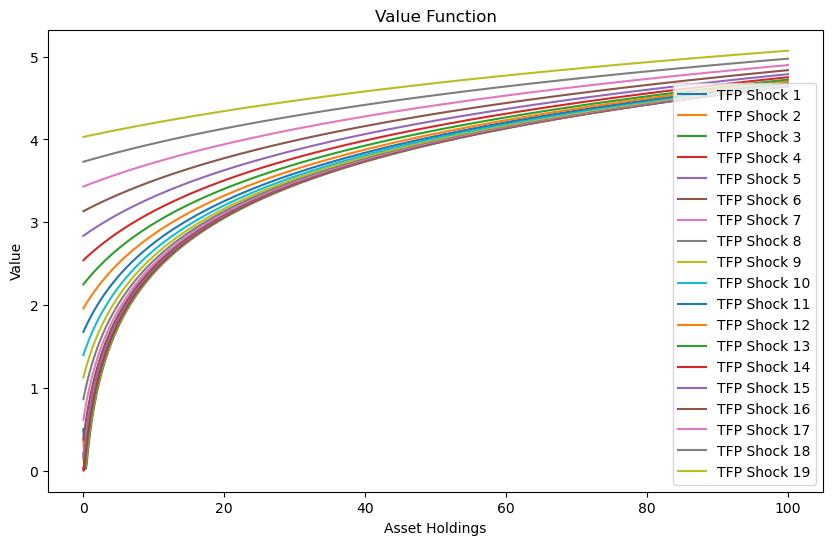

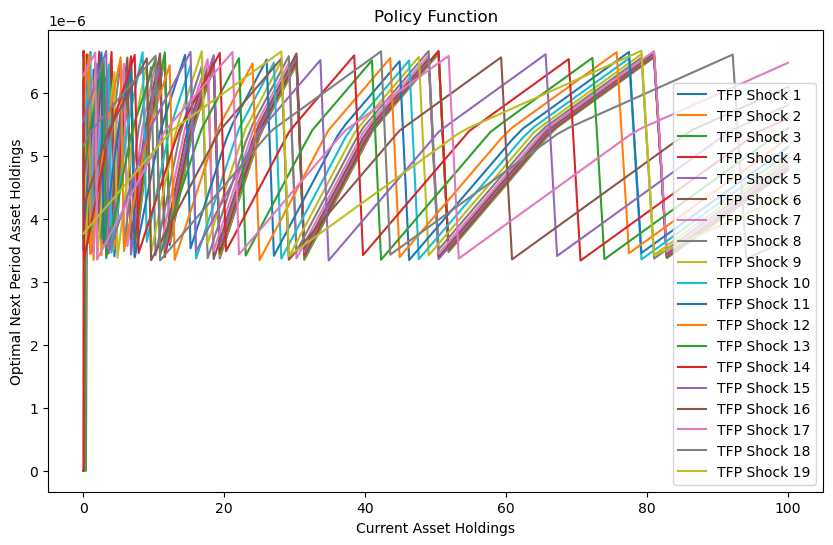

In [231]:
V_out, G_out = iterate(P, r=0.03, w=0.5, b=4.0, toler=1e-8, max_iter=100000)

Create a function which will find the first element of an array for which the predicate is true

In [233]:
def findfirst(predicate, array):
    for i, x in enumerate(array):
        if predicate(x):
            return i
        else:
            return print("None")

Next, create the function to calculate the invariant distribution.

In [234]:
def Invariant_Distirbution(params, policy, transition_matrix, grid):
   # M(i, j, k, l) -> current state: (i,j), next state: (k,l)
    M = np.zeros(shape=(params[0], params[3], params[0], params[3]))
   # for i in range(n_a):
    for i in range(params[0]):
       # for j in range(n_z):
        for j in range(params[3]):
           # if G1[i,j]<=np.squeeze(grid[1]):
            if policy[i,j]<=np.min(grid):
               # if you stay at the borrowing constraint across periods, your transition is only affected by evolution of AR1 process. 
                M[i,j,1,:] = transition[j,:]

            elif policy[i,j]>=np.max(grid):
               # if you stay at the max asset holdings across periods, your transition is only affected by evolution of AR1 process.
                M[i,j,params[0],:] = transition[j,:]

            else:
                
              # Some explanation is required for this step.
              # The "findfirst" function is defined above. There, we ask Python to look at the row vector, and return 
              # the index of the first element where the predicate is true.
                
                index = findfirst(lambda x: x > policy[i,j], grid)
                
              # Individuals have chosen policy[i,j] from a continuous choice set.
              # However, policy[i,j] may not necessarily lie on our asset grid. We need to move them to a grid point.
              # We linearly intepolate a probability based on the position of policy[i,j] with regard to the grid points closest.
              # Individuals are more likely to transition to whichever grid point is closer.
                
                prob = (grid[index] - policy[i,j])/(grid[index] - grid[index-1])
                
                M[i,j,index-1,:] = transition[j,:]*prob
                
                M[i,j,index,:] = transition[j,:]*(1-prob)

    O = M.reshape(shape=(params[0] * params[3], params[0] * params[3]))

   #### Matteo's implementation in Julia. ####
    
   # O = np.zeros(shape=(params[0] * params[3], params[0] * params[3]))
                 
   # l=0
    
   # for i in range(params[0]):
        
       # for j in range(params[3]):
            
          #  O[:,j+l*params[3]]  = M[:,:,i,j].T.flatten()

      #  l=l+1
    
   #### Matteo's implementation in Julia. ####
    
    # Make sure that O is a Markov chain
    for i in range(params[0]*params[3]):

        O[i, :] = (O[i, :]) / (np.sum(O[i, :]))

    number_of_states = (params[0]*params[3])
    
    # What are we doing here?
    # We need to solve the system which calculates the invariant distribution, pi*P = pi. We also
    # need the extra condition that elements of pi must some to 1 such that we have an invariant prob dist. Therefore, the code below
    # solve this modified system of linear equations. Note that we have 0 = pi* (I - P)
    X = np.vstack([(np.eye(number_of_states) - O.T), np.ones(number_of_states)])

    Invariant = np.linalg.lstsq(X.T, np.concatenate(np.zeros(number_of_states), [1]), rcond=None)[0]

    Pi = Invariant[:-1].reshape((params[0], params[3]))
    
    Pi[Pi < 0] = 0

    Pi = Pi / np.sum(Pi)

    return Pi

Function to calculate the Aiyagari equilibrium

In [238]:
def Aiyagari_equilibrium(r, params, tfp, alpha, toler, tolerV, max_iter, b):

    z_grid, T = Markov_chain(params)

    asset_grid = expanding_grid(params)
    
    error = 1

    # We need an initial distribution 
    initial_dist = np.zeros(shape=(params[0] * params[3], 1))

    # We also need to calculate the invariant distribution of the labour income process
    
    Invariant_Labour_Process = np.vstack([(np.eye(params[3]) - T.T), np.ones(params[3])])
    # print(np.shape(Invariant_Labour_Process)) shape = (20, 19)
    # print(Invariant_Labour_Process[19, :]) check that the last row is all ones

    # mu = np.linalg.lstsq(Invariant_Labour_Process.T, np.concatenate(np.zeros(19), [1]), rcond=None)[0]
    ones = np.ones(1)
    sol = np.concatenate((np.zeros(19), ones)).reshape(-1,1)
    #print(np.shape(sol))
    # mu = np.linalg.lstsq(Invariant_Labour_Process.T, np.concatenate((np.zeros(19), ones)))
    
    mu = np.linalg.lstsq(Invariant_Labour_Process, sol, rcond=None)[0]
    # print(mu)
    L = np.zeros(19).reshape(-1,1)
    for i in range(params[3]):
        L[i] = mu[i] * z_grid[i]
    print(L)
    # L = mu * z_grid

    
    r_steady_state = (1/params[1]) - 1

    V = np.zeros(shape=(params[0], params[3]))
    G = np.zeros(shape=(params[0], params[3]))

    V0 = np.zeros(shape=(params[0], params[3]))
    G0 = np.zeros(shape=(params[0], params[3]))
    
    rnew = r_steady_state

    Ks, Kd = 1, 1

    w = 1

    phi = 0

    price_iter = 0

    while error < toler and price_iter <= (max_iter/1000):

        r_init  = (r + rnew) / 2

        Kd = ( (tfp * alpha * L ** ( 1 - alpha)) / (r_init + delta) ) ** ( 1 / ( 1 - alpha ) )

        w = tfp * ( 1 - alpha ) * ( Kd ** alpha ) * ( L ** -alpha ) 

        if b > 0 :

            phi = np.min([b, (w * np.min(Z))/r_init])

        else:

            phi = b

        V, G = iterate(params, r_init, w, b, tolerV, max_iter)

        p0 = Invariant_Distirbution(params, G, T, asset_grid)
   
        pol = np.reshape(G - phi, (params[0] * params[3], 1))

        Ks = pol*p0

        diff = Ks - Kd

        if diff > 0:

            rnew = r_init

        else: 
            r = r_init

        error = np.abs(diff)

        V0 = V

        if price_iter % 10 == 0:
             print(f"Iteration {iter}, Error: {error}, Prices: {rnew, r}, Quantities: { Ks, Kd}")

        price_iter += 1
        
        if error < toler:
            print(f"Converged in {iter + 1} iterations")
            break

        if price_iter == max_iter:
            print(f"failed to converge in {max_iter} iterations")
            break
    
        
    return Ks, Kd, r, w, V, G, p0
    

In [239]:
Ks, Kd, r, w, V, G, p0 = Aiyagari_equilibrium(1, P, 2.5, 0.33, toler=1e-8, tolerV=1e-12, max_iter=100000, b=4.0)

[[-2.73691132e-06]
 [-2.85317921e-05]
 [-6.62930334e-05]
 [ 5.86315553e-04]
 [ 5.72322731e-03]
 [ 2.58937596e-02]
 [ 7.74853794e-02]
 [ 1.69487337e-01]
 [ 2.83446067e-01]
 [ 3.70941162e-01]
 [ 3.84248025e-01]
 [ 3.16108367e-01]
 [ 2.05778781e-01]
 [ 1.04843545e-01]
 [ 4.09686672e-02]
 [ 1.18648563e-02]
 [ 2.40088776e-03]
 [ 3.03189995e-04]
 [ 1.79957004e-05]]


C:\Users\bayle\AppData\Local\Temp\ipykernel_24056\598050104.py:6: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)


UnboundLocalError: local variable 'p0' referenced before assignment